## 环境配置 & 数据下载

In [ ]:
# !git clone https://github.com/FoundationVision/VAR.git 

In [1]:
import os
import sys
if os.path.exists('VAR'):
    os.chdir('VAR')
    if 'PyPath' not in globals():
        PyPath=sys.executable
    os.makedirs('weight',exist_ok=True)
    os.makedirs('data',exist_ok=True)
    os.makedirs('result',exist_ok=True)
    os.makedirs('log',exist_ok=True)

In [ ]:
# PyPath='/data1/student/stx/anaconda3/envs/fid/bin/python' # tensorflow的python环境，可选用其他环境
# os.environ['QUALITY_PY']=PyPath

In [ ]:
# %pip install -r requirements.txt
# %pip install tensorflow scipy pandas
# %pip install kaggle (需要配置文件)
# !kaggle competitions download -c imagenet-object-localization-challenge -p data/imagenet

In [ ]:
#!wget https://github.com/openai/guided-diffusion/raw/refs/heads/main/evaluations/evaluator.py -O evaluator.py
#!mkdir data/imagenetnpz
# !wget https://openaipublic.blob.core.windows.net/diffusion/jul-2021/ref_batches/imagenet/256/VIRTUAL_imagenet256_labeled.npz -O data/imagenetnpz/VIRTUAL_imagenet256_labeled.npz

--2024-12-23 15:20:13--  https://github.com/openai/guided-diffusion/raw/refs/heads/main/evaluations/evaluator.py
Connecting to 127.0.0.1:20010... connected.
Proxy request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/openai/guided-diffusion/refs/heads/main/evaluations/evaluator.py [following]
--2024-12-23 15:20:13--  https://raw.githubusercontent.com/openai/guided-diffusion/refs/heads/main/evaluations/evaluator.py
Connecting to 127.0.0.1:20010... connected.
Proxy request sent, awaiting response... 200 OK
Length: 25057 (24K) [text/plain]
Saving to: ‘evaluator.py’

evaluator.py        100%[===================>]  24.47K  --.-KB/s    in 0.05s   

2024-12-23 15:20:14 (478 KB/s) - ‘evaluator.py’ saved [25057/25057]



In [2]:
import json 
import pandas as pd
import os.path as osp
import torch, torchvision
import random
import subprocess
import numpy as np
import PIL.Image as PImage
from typing import List, Optional, Union
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from models.var import AdaLNSelfAttn, sample_with_top_k_top_p_, gumbel_softmax_with_rng


## 定性测试

### 模型加载与工具构建

In [18]:
################## 1. Download checkpoints and build models
setattr(torch.nn.Linear, 'reset_parameters', lambda self: None)     # disable default parameter init for faster speed
setattr(torch.nn.LayerNorm, 'reset_parameters', lambda self: None)  # disable default parameter init for faster speed
from models import VQVAE, build_vae_var

# we recommend using imagenet-512-d36 model to do the in-painting & out-painting & class-condition editing task
MODEL_DEPTH = 20    # TODO: =====> please specify MODEL_DEPTH <=====
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cuda:1'
assert MODEL_DEPTH in {16, 20, 24, 30, 36}


# download checkpoint
hf_home = 'https://huggingface.co/FoundationVision/var/resolve/main'
vae_ckpt, var_ckpt = 'vae_ch160v4096z32.pth', f'var_d{MODEL_DEPTH}.pth'
if not osp.exists(f'weight/{vae_ckpt}'): os.system(f'wget {hf_home}/{vae_ckpt} -O weight/{vae_ckpt}')
if not osp.exists(f'weight/{var_ckpt}'): os.system(f'wget {hf_home}/{var_ckpt} -O weight/{var_ckpt}')

# build vae, var

FOR_512_px = MODEL_DEPTH == 36
if FOR_512_px:
    hw = 512
    patch_nums = (1, 2, 3, 4, 6, 9, 13, 18, 24, 32)
else:
    hw = 256
    patch_nums = (1, 2, 3, 4, 5, 6, 8, 10, 13, 16)

vae, var = build_vae_var(
    V=4096, Cvae=32, ch=160, share_quant_resi=4,    # hard-coded VQVAE hyperparameters
    device=device, patch_nums=patch_nums,
    num_classes=1000, depth=MODEL_DEPTH, shared_aln=FOR_512_px,
)

# load checkpoints
vae.load_state_dict(torch.load(f'weight/{vae_ckpt}', map_location='cpu'), strict=True)
var.load_state_dict(torch.load(f'weight/{var_ckpt}', map_location='cpu'), strict=True)
vae.eval(), var.eval()
for p in vae.parameters(): p.requires_grad_(False)
for p in var.parameters(): p.requires_grad_(False)
print(f'preparation finished.')


[constructor]  ==== flash_if_available=True (20/20), fused_if_available=True (fusing_add_ln=0/20, fusing_mlp=0/20) ==== 
    [VAR config ] embed_dim=1280, num_heads=20, depth=20, mlp_ratio=4.0
    [drop ratios ] drop_rate=0.0, attn_drop_rate=0.0, drop_path_rate=0.0833333 (tensor([0.0000, 0.0044, 0.0088, 0.0132, 0.0175, 0.0219, 0.0263, 0.0307, 0.0351,
        0.0395, 0.0439, 0.0482, 0.0526, 0.0570, 0.0614, 0.0658, 0.0702, 0.0746,
        0.0789, 0.0833]))

[init_weights] VAR with init_std=0.0161374


/tmp/ipykernel_872511/3876002853.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(f'weight/{vae_ckpt}', map_location='cpu'), strict=True)


preparation finished.


In [4]:
################## 2. Define some helper functions for zero-shot editing
def get_edit_mask(patch_nums: List[int], y0: float, x0: float, y1: float, x1: float, device, inpainting: bool = True) -> torch.Tensor:
    ph, pw = patch_nums[-1], patch_nums[-1]
    edit_mask = torch.zeros(ph, pw, device=device)
    edit_mask[round(y0 * ph):round(y1 * ph), round(x0 * pw):round(x1 * pw)] = 1 # outpainting mode: center would be gt
    if inpainting:
        edit_mask = 1 - edit_mask   # inpainting mode: center would be model pred
    return edit_mask    # a binary mask, 1 for keeping the tokens of the image to be edited; 0 for generating new tokens (by VAR)


# overwrite the function of 'VAR::autoregressive_infer_cfg'
def autoregressive_infer_cfg_with_mask(
    self, B: int, label_B: Optional[Union[int, torch.LongTensor]],
    g_seed: Optional[int] = None, cfg=1.5, top_k=0, top_p=0.0,
    more_smooth=False,
    input_img_tokens: Optional[List[torch.Tensor]] = None, edit_mask: Optional[torch.Tensor] = None,
) -> torch.Tensor:   # returns reconstructed image (B, 3, H, W) in [0, 1]
    """
    only used for inference, on autoregressive mode
    :param B: batch size
    :param label_B: imagenet label; if None, randomly sampled
    :param g_seed: random seed
    :param cfg: classifier-free guidance ratio
    :param top_k: top-k sampling
    :param top_p: top-p sampling
    :param more_smooth: smoothing the pred using gumbel softmax; only used in visualization, not used in FID/IS benchmarking
    :param input_img_tokens: (optional, only for zero-shot edit tasks) tokens of the image to be edited
    :param edit_mask: (optional, only for zero-shot edit tasks) binary mask, 1 for keeping given tokens; 0 for generating new tokens
    :return: if returns_vemb: list of embedding h_BChw := vae_embed(idx_Bl), else: list of idx_Bl
    """
    if g_seed is None: rng = None
    else: self.rng.manual_seed(g_seed); rng = self.rng

    if label_B is None:
        label_B = torch.multinomial(self.uniform_prob, num_samples=B, replacement=True, generator=rng).reshape(B)
    elif isinstance(label_B, int):
        label_B = torch.full((B,), fill_value=self.num_classes if label_B < 0 else label_B, device=self.lvl_1L.device)

    sos = cond_BD = self.class_emb(torch.cat((label_B, torch.full_like(label_B, fill_value=self.num_classes)), dim=0))

    lvl_pos = self.lvl_embed(self.lvl_1L) + self.pos_1LC
    next_token_map = sos.unsqueeze(1).expand(2 * B, self.first_l, -1) + self.pos_start.expand(2 * B, self.first_l, -1) + lvl_pos[:, :self.first_l]

    cur_L = 0
    f_hat = sos.new_zeros(B, self.Cvae, self.patch_nums[-1], self.patch_nums[-1])

    for b in self.blocks: b.attn.kv_caching(True)
    for si, pn in enumerate(self.patch_nums):   # si: i-th segment
        ratio = si / self.num_stages_minus_1
        # last_L = cur_L
        cur_L += pn*pn
        # assert self.attn_bias_for_masking[:, :, last_L:cur_L, :cur_L].sum() == 0, f'AR with {(self.attn_bias_for_masking[:, :, last_L:cur_L, :cur_L] != 0).sum()} / {self.attn_bias_for_masking[:, :, last_L:cur_L, :cur_L].numel()} mask item'
        cond_BD_or_gss = self.shared_ada_lin(cond_BD)
        x = next_token_map
        AdaLNSelfAttn.forward
        for b in self.blocks:
            x = b(x=x, cond_BD=cond_BD_or_gss, attn_bias=None)
        logits_BlV = self.get_logits(x, cond_BD)

        t = cfg * ratio
        logits_BlV = (1+t) * logits_BlV[:B] - t * logits_BlV[B:]

        idx_Bl = sample_with_top_k_top_p_(logits_BlV, rng=rng, top_k=top_k, top_p=top_p, num_samples=1)[:, :, 0]
        if not more_smooth: # this is the default case
            h_BChw = self.vae_quant_proxy[0].embedding(idx_Bl)   # B, l, Cvae
        else:   # not used when evaluating FID/IS/Precision/Recall
            gum_t = max(0.27 * (1 - ratio * 0.95), 0.005)   # refer to mask-git
            h_BChw = gumbel_softmax_with_rng(logits_BlV.mul(1 + ratio), tau=gum_t, hard=False, dim=-1, rng=rng) @ self.vae_quant_proxy[0].embedding.weight.unsqueeze(0)

        h_BChw = h_BChw.transpose_(1, 2).reshape(B, self.Cvae, pn, pn)
        if edit_mask is not None:
            gt_BChw = self.vae_quant_proxy[0].embedding(input_img_tokens[si]).transpose_(1, 2).reshape(B, self.Cvae, pn, pn)
            h_BChw = replace_embedding(edit_mask, h_BChw, gt_BChw, pn, pn)

        f_hat, next_token_map = self.vae_quant_proxy[0].get_next_autoregressive_input(si, len(self.patch_nums), f_hat, h_BChw)
        if si != self.num_stages_minus_1:   # prepare for next stage
            next_token_map = next_token_map.view(B, self.Cvae, -1).transpose(1, 2)
            next_token_map = self.word_embed(next_token_map) + lvl_pos[:, cur_L:cur_L + self.patch_nums[si+1] ** 2]
            next_token_map = next_token_map.repeat(2, 1, 1)   # double the batch sizes due to CFG

    for b in self.blocks: b.attn.kv_caching(False)
    return self.vae_proxy[0].fhat_to_img(f_hat).add_(1).mul_(0.5)


def replace_embedding(edit_mask: torch.Tensor, h_BChw: torch.Tensor, gt_BChw: torch.Tensor, ph: int, pw: int) -> torch.Tensor:
    B = h_BChw.shape[0]
    h, w = edit_mask.shape[-2:]
    if edit_mask.ndim == 2:
        edit_mask = edit_mask.unsqueeze(0).expand(B, h, w)

    force_gt_B1hw = F.interpolate(edit_mask.unsqueeze(1).to(dtype=torch.float, device=gt_BChw.device), size=(ph, pw), mode='bilinear', align_corners=False).gt(0.5).int()
    if ph * pw <= 3: force_gt_B1hw.fill_(1)
    return gt_BChw * force_gt_B1hw + h_BChw * (1 - force_gt_B1hw)


### 先进的图像生成 & 缩放效应的可视化

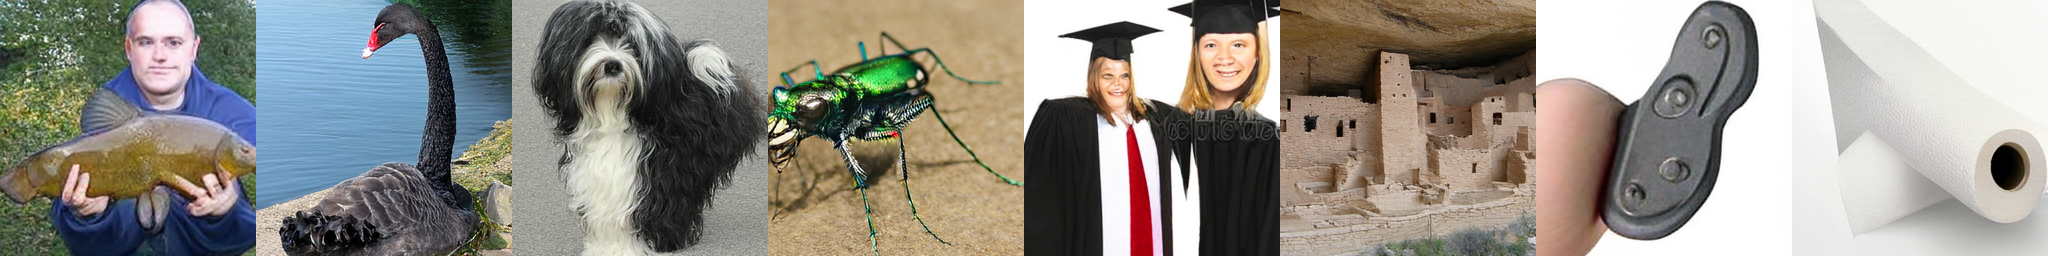

In [8]:
############################# 2. Sample with classifier-free guidance
# set args
seed = 0 #@param {type:"number"}
num_sampling_steps = 250 #@param {type:"slider", min:0, max:1000, step:1}
cfg = 5 #@param {type:"slider", min:1, max:10, step:0.1}
class_labels = (0,100,200,300,400,500,600,700)  #@param {type:"raw"}
more_smooth = True # True for more smooth output

# seed
if seed is not None:
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# run faster
tf32 = True
torch.backends.cudnn.allow_tf32 = bool(tf32)
torch.backends.cuda.matmul.allow_tf32 = bool(tf32)
torch.set_float32_matmul_precision('high' if tf32 else 'highest')

# sample
B = len(class_labels)
label_B: torch.LongTensor = torch.tensor(class_labels, device=device)
with torch.inference_mode():
    with torch.autocast('cuda', enabled=True, dtype=torch.float16, cache_enabled=True):    # using bfloat16 can be faster
        recon_B3HW = var.autoregressive_infer_cfg(B=B, label_B=label_B, cfg=cfg, top_k=900, top_p=0.95, g_seed=seed, more_smooth=more_smooth)

chw = torchvision.utils.make_grid(recon_B3HW, nrow=8, padding=0, pad_value=1.0)
chw = chw.permute(1, 2, 0).mul_(255).cpu().numpy()
chw = PImage.fromarray(chw.astype(np.uint8))
chw  

### 零样本泛化任务

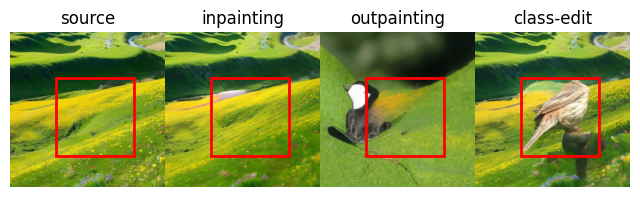

In [21]:
############################# 3. Sample with classifier-free guidance
os.makedirs('data/test',exist_ok=True)
#!wget "https://img1.baidu.com/it/u=1838483471,2807690084&fm=253&fmt=auto&app=138&f=JPEG?w=800&h=1455" -O "data/test/0.jpeg"
# set args
img_to_be_edited='data/test/0.jpeg'
x0,y0,x1,y1=0.3,0.3,0.8,0.8
# edit to class label, if it was set to 0-999, it's an class condition editing task
# if it was set to 1000, it's an in-painting task

class_label = 12  #@param {type:"raw"}
seed = 6662 #@param {type:"number"}
cfg = 4 #@param {type:"slider", min:1, max:10, step:0.1}
more_smooth = False # True for more smooth output

# seed
if seed is not None:
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# run faster
tf32 = True
torch.backends.cudnn.allow_tf32 = bool(tf32)
torch.backends.cuda.matmul.allow_tf32 = bool(tf32)
torch.set_float32_matmul_precision('high' if tf32 else 'highest')

# load the image to be edited
from utils.data import pil_loader, normalize_01_into_pm1
from torchvision.transforms import transforms

T=transforms.Compose([transforms.Resize(hw),transforms.RandomCrop(hw)])
img=T(pil_loader(img_to_be_edited))
input_img = normalize_01_into_pm1(transforms.ToTensor()(img)).unsqueeze(0).to(device=device)
input_img_tokens = vae.img_to_idxBl(input_img, var.patch_nums)

# zero-shot edit
# The inpainting parameter controls whether the task is inpainting or outpainting
edit_mask = get_edit_mask(
    var.patch_nums,
    y0=y0, x0=x0,
    y1=y1, x1=x1,
    device=device, inpainting=True,
)
B = 1
def get_image(class_label,inpainting=True):
    label_B: torch.LongTensor = torch.tensor([class_label], device=device)
    with torch.inference_mode():
        with torch.autocast('cuda', enabled=True, dtype=torch.float16, cache_enabled=True):    # using bfloat16 can be faster
            recon_B3HW = autoregressive_infer_cfg_with_mask(
                var,
                B=B, label_B=label_B, cfg=3, top_k=900, top_p=0.95, g_seed=seed, more_smooth=True,
                input_img_tokens=input_img_tokens, edit_mask=edit_mask if inpainting else 1-edit_mask
            )
            chw = torchvision.utils.make_grid(recon_B3HW, nrow=8, padding=0, pad_value=1.0)
            chw = chw.permute(1, 2, 0).mul(255).cpu().numpy()
            chw = PImage.fromarray(chw.astype(np.uint8))
    return chw

fig,axs=plt.subplots(1,4,figsize=(8,8))
plt.subplots_adjust(wspace=0,hspace=0)
imgs=[img,get_image(1000,True),get_image(1000,False),get_image(class_label,True)]
ts=['source','inpainting','outpainting','class-edit']

for ax,im,t in zip(axs.flat,imgs,ts):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(t)
    rect = patches.Rectangle((int(x0*hw), int(y0*hw)), int((x1-x0)*hw),int((y1-y0)*hw), linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
plt.show()


## 定量测试

### 自动化脚本

In [40]:
pipe=subprocess.Popen("python ../auto.py",shell=True)
pipe.wait()

warming up TensorFlow...
computing reference batch activations...
computing/reading reference batch statistics...
computing sample batch activations...
computing/reading sample batch statistics...
Computing evaluations...
Inception Score: 304.04534912109375
FID: 2.7096886502766324
sFID: 7.460417834311215
Precision: 0.83712
Recall: 0.5557

2024-12-24 15:45:13.548378: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735026313.565989  614216 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735026313.571219  614216 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-24 15:45:13.590345: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow

/data1/student/stx/ML/数学建模/project/VAR/../scale.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(f'weight/{vae_ckpt}', map_location='cpu'

preparation finished.
begin sample!
Err_last:0.97939453125
Err_all:0.991611755490303
L_last:5.612818098068237
L_all:6.631407384872436
1% complete
Err_last:0.97567138671875
Err_all:0.9900768405199051
L_last:5.448214483261109
L_all:6.550965445041657
2% complete
Err_last:0.9750406901041667
Err_all:0.987585196296374
L_last:5.459722582499186
L_all:6.548909997145334
3% complete
Err_last:0.97664794921875
Err_all:0.9890159505605698
L_last:5.5113118410110475
L_all:6.63808407485485
4% complete
Err_last:0.9773193359375
Err_all:0.9896653169393539
L_last:5.541660270690918
L_all:6.674605559825897
5% complete
Err_last:0.9772237141927084
Err_all:0.9900726765394211
L_last:5.5395227114359535
L_all:6.709063371419907
6% complete
Err_last:0.97783203125
Err_all:0.9902797805411473
L_last:5.552360759462629
L_all:6.73589553117752
7% complete
Err_last:0.9770004272460937
Err_all:0.9898902504891158
L_last:5.522812557220459
L_all:6.702649055719375
8% complete
Err_last:0.9771443684895833
Err_all:0.9898980474472047


0

### 图像质量与实际推理时间

In [47]:
with open('log/quality.json','r') as f:
    q = json.load(f)
with open('log/time.json','r') as f:
    p = json.load(f)
df=pd.DataFrame(columns=["depth","inception_score","fid","precision","recall","time"])
for key,value in q.items():
    value["depth"]=key
    value["time"]=p.get(key,'--')
    df.loc[len(df)]=value
df

,depth,inception_score,fid,precision,recall,time
0,16,279.159821,3.574164,0.84590,0.4989,2718.19203
1,20,304.045349,2.709689,0.83712,0.5557,3401.28391


### 尺度定律

这一步的工作量较大，我们只提供了计算论文中$Err_{last}, Err_{all}, L_{last}, L_{all}$的脚本。

In [46]:
with open('log/scale.json','r') as f:
    q = json.load(f)
df=pd.DataFrame(columns=["depth","Err_all","Err_last","L_all","L_last"])
for key,value in q.items():
    value["depth"]=key
    df.loc[len(df)]=value
df

,depth,Err_all,Err_last,L_all,L_last
0,16,0.990000,0.980000,6.440000,5.450000
1,20,0.985938,0.968562,6.485286,5.226293
